In [1]:
import TimeSliceImport
import numpy as np
import gc
import keras
from sklearn import (metrics,preprocessing)
import RamanPlotTools as pt
import matplotlib.pyplot as plt
from keras.callbacks import (EarlyStopping,ModelCheckpoint)
from keras import backend as K


Using TensorFlow backend.


In [2]:
from keras.backend import tensorflow_backend as backend
print(backend.device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9321078945411095473
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7356298036
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2692117922582208358
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
path="/home/waseda/Desktop/shared/SKYP_KYP_SYP"
outPath="/home/waseda/Desktop/models/"
numClasses=4
types=["PS", "yeast","spore","kleb"]
spectra=TimeSliceImport.importData(path,types)
classes=list(map(lambda x:TimeSliceImport.RamanSample.mappings[x],types))
sortedTypesTuples=sorted(zip(types,classes),key=lambda x:x[1])
sortedTypes=[x[0] for x in sortedTypesTuples]

startPNT=201


def makeRandomData(start=startPNT,end=1600,points=1000):
    trainingSamples, validationSamples = TimeSliceImport.splitData(spectra, 0.25)
    trainingSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points), trainingSamples))
    validationSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points), validationSamples))
    
    trainingData,trainingClasses,validationData,validationClasses = TimeSliceImport.makeSVMInputData(trainingSpectraList,
                                                                                                     validationSpectraList,normalize=False)
    
   
    
    oneHotTrainingClasses=keras.utils.to_categorical(trainingClasses,num_classes=numClasses)
    oneHotValidationClasses=keras.utils.to_categorical(validationClasses,num_classes=numClasses)
    return trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses

trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData()


def scalarClassesFromOneHotArray(oneHotArray):
    return np.argmax(oneHotArray,axis=1)

def plotResult(truth,result, score, normalize=False):
    pt.plotResult(scalarClassesFromOneHotArray(result),scalarClassesFromOneHotArray(truth),sortedTypes)
    mtrx = metrics.confusion_matrix(scalarClassesFromOneHotArray(truth),scalarClassesFromOneHotArray(result))
    pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % score, normalize=normalize)

def plotLearning(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training Loss', 'Cross-Validation Loss'])
    plt.show()


In [4]:
from mcfly.modelgen import *

cnn_min_layers=1
cnn_max_layers=10
cnn_min_filters=10
cnn_max_filters=64
cnn_min_fc_nodes=10
cnn_max_fc_nodes=1000
deepconvlstm_min_conv_layers=1
deepconvlstm_max_conv_layers=10
deepconvlstm_min_conv_filters=10
deepconvlstm_max_conv_filters=64
deepconvlstm_min_lstm_layers=1
deepconvlstm_max_lstm_layers=5
deepconvlstm_min_lstm_dims=10
deepconvlstm_max_lstm_dims=100
low_lr=1
high_lr=4
low_reg=1
high_reg=4

def makeModel(x_shape,number_of_classes=4):
    metrics=["accuracy"]
    current_model_type = 'CNN' if np.random.random() < 0.5 else 'DeepConvLSTM'
    generate_model = None
    if current_model_type == 'CNN':
        generate_model = generate_CNN_model  # generate_model is a function
        hyperparameters = generate_CNN_hyperparameter_set(
            min_layers=cnn_min_layers, max_layers=cnn_max_layers,
            min_filters=cnn_min_filters, max_filters=cnn_max_filters,
            min_fc_nodes=cnn_min_fc_nodes, max_fc_nodes=cnn_max_fc_nodes,
            low_lr=low_lr, high_lr=high_lr, low_reg=low_reg,
            high_reg=high_reg)
    if current_model_type == 'DeepConvLSTM':
        generate_model = generate_DeepConvLSTM_model
        hyperparameters = generate_DeepConvLSTM_hyperparameter_set(
            min_conv_layers=deepconvlstm_min_conv_layers,
            max_conv_layers=deepconvlstm_max_conv_layers,
            min_conv_filters=deepconvlstm_min_conv_filters,
            max_conv_filters=deepconvlstm_max_conv_filters,
            min_lstm_layers=deepconvlstm_min_lstm_layers,
            max_lstm_layers=deepconvlstm_max_lstm_layers,
            min_lstm_dims=deepconvlstm_min_lstm_dims,
            max_lstm_dims=deepconvlstm_max_lstm_dims,
            low_lr=low_lr, high_lr=high_lr, low_reg=low_reg,
            high_reg=high_reg)
    
    # models.append(
    #     (generate_model(x_shape, number_of_classes, metrics=metrics,compile=compile, **hyperparameters),
    #      hyperparameters, current_model_type))
    
    return generate_model(x_shape, number_of_classes, metrics=metrics, **hyperparameters),hyperparameters,current_model_type

In [6]:
def runModelSearch(numberOfModels=2,numberOfRepetitions=1):
    
    histories = []
    val_metrics = []
    val_losses = []
    parameters=[]
    nr_epochs=50
    batch_size=20
    verbose=0
    modelnames=[]
    callbacks = [
                # EarlyStopping(monitor='val_loss', patience=10, verbose=verbose, mode='auto')
                ]
    
    rangeEnd=1200
    dist=rangeEnd-startPNT
    
    trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData(start=startPNT,
                                                                                                    end=rangeEnd,
                                                                                                    points=dist)
            
    reshapedTraining = np.expand_dims(trainingData, axis=2)
    reshapedValidation = np.expand_dims(validationData, axis=2)
    
    
    for idx in range(numberOfModels):
        
        model,hyperparameters,type=makeModel(reshapedTraining.shape,number_of_classes=numClasses)
        modelName="{}_{}.hdf5".format(type,idx)
        print('Training Model {}'.format(modelName))
        print(model.summary())
        modelnames.append(modelName)
        callbacks.append(ModelCheckpoint(outPath+modelName))
        parameters.append(hyperparameters)
        
        history = model.fit(reshapedTraining, oneHotTrainingClasses,
                            epochs=nr_epochs,
                            validation_data=(reshapedValidation, oneHotValidationClasses),
                            verbose=verbose,
                            callbacks=callbacks)
        
        histories.append(history)
        prd = model.predict(reshapedValidation)
        
        val_metrics.append(history.history['val_' + "acc"][-1])
        val_losses.append(history.history['val_loss'][-1])
        
        print("Accuracy {}".format(history.history["val_acc"][-1]))
        plotLearning(history)
        
        K.clear_session()
        del history
        del model
        gc.collect()
        
    return val_metrics,parameters,modelnames

Training Model DeepConvLSTM_0.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
reshape_1 (Reshape)          (None, 999, 1, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 999, 1, 16)        64        
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 1, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 999, 1, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 999, 1, 25)        1225      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999, 

Accuracy 0.19047619047619047


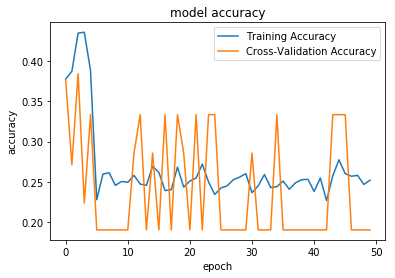

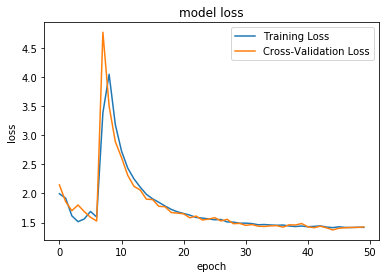

Training Model DeepConvLSTM_1.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
reshape_1 (Reshape)          (None, 999, 1, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 999, 1, 59)        236       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 1, 59)        236       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 1, 59)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 999, 59)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 999, 

Accuracy 0.19047619047619047


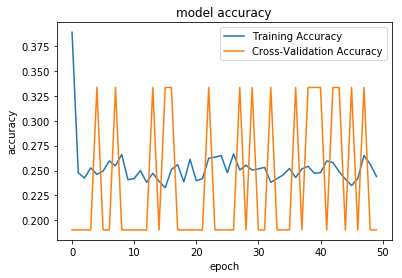

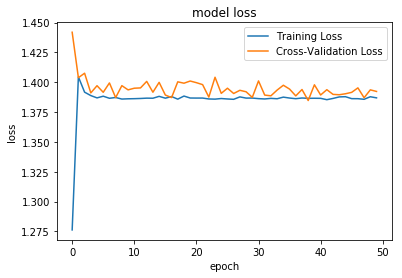

Training Model CNN_2.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 999, 18)           72        
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 18)           72        
_________________________________________________________________
activation_1 (Activation)    (None, 999, 18)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 999, 34)           1870      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999, 34)           136       
_________________________________________________________________
activation_2 (Activation)    (None, 999, 34)      

Accuracy 0.21428571428571427


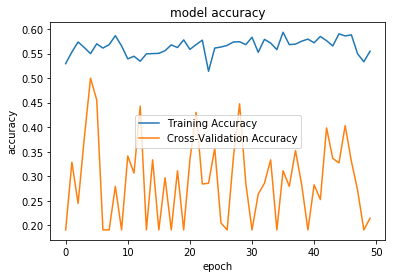

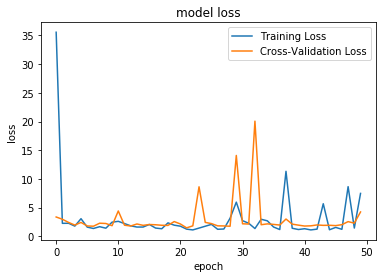

Training Model CNN_3.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 999, 46)           184       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 46)           184       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 46)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 999, 31)           4309      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999, 31)           124       
_________________________________________________________________
activation_2 (Activation)    (None, 999, 31)      

Accuracy 0.4


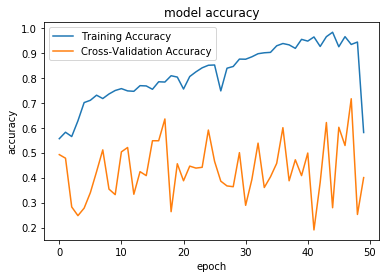

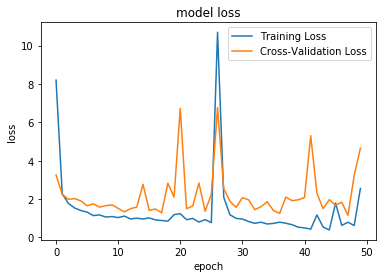

Training Model DeepConvLSTM_4.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
reshape_1 (Reshape)          (None, 999, 1, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 999, 1, 50)        200       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 1, 50)        200       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 1, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 999, 1, 45)        6795      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999, 

Accuracy 0.4682539684904946


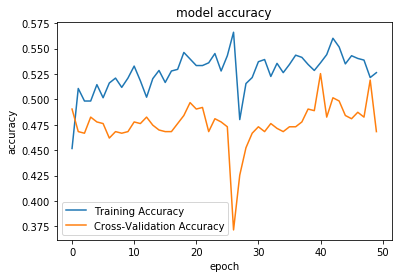

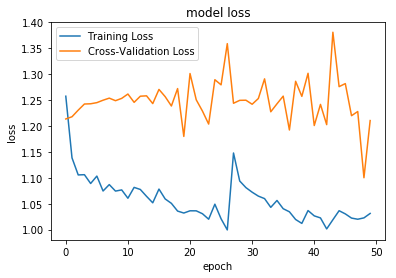

Training Model CNN_5.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 999, 10)           40        
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 10)           40        
_________________________________________________________________
activation_1 (Activation)    (None, 999, 10)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 999, 56)           1736      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999, 56)           224       
_________________________________________________________________
activation_2 (Activation)    (None, 999, 56)      

Accuracy 0.3333333333333333


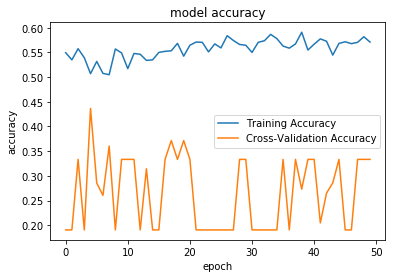

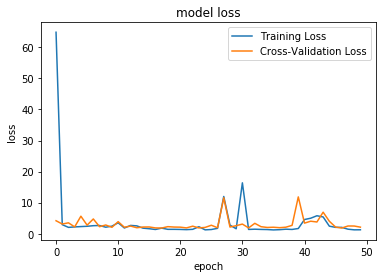

Training Model CNN_6.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 999, 55)           220       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 55)           220       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 55)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 999, 32)           5312      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999, 32)           128       
_________________________________________________________________
activation_2 (Activation)    (None, 999, 32)      

Accuracy 0.7301587301587301


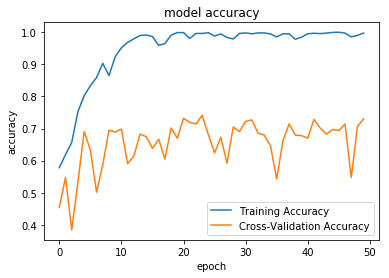

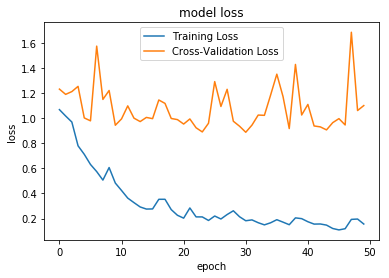

Training Model DeepConvLSTM_7.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
reshape_1 (Reshape)          (None, 999, 1, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 999, 1, 43)        172       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 1, 43)        172       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 1, 43)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 999, 1, 59)        7670      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999, 

Accuracy 0.19047619047619047


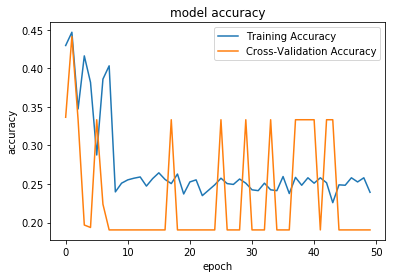

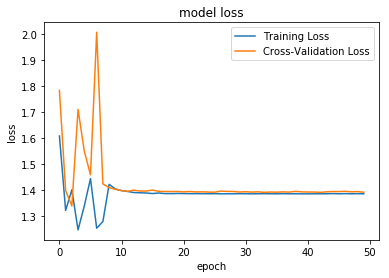

Training Model DeepConvLSTM_8.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
reshape_1 (Reshape)          (None, 999, 1, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 999, 1, 57)        228       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 1, 57)        228       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 1, 57)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 999, 1, 29)        4988      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999, 

Accuracy 0.47936507941238465


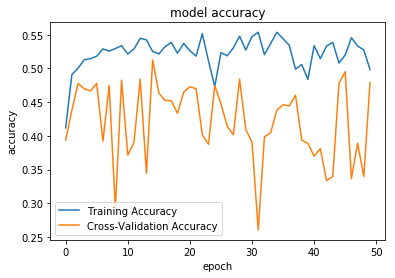

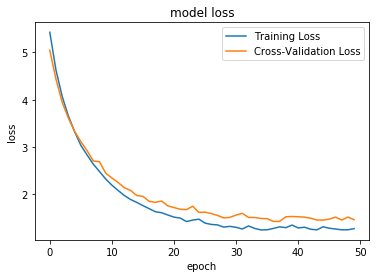

Training Model DeepConvLSTM_9.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
reshape_1 (Reshape)          (None, 999, 1, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 999, 1, 28)        112       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 1, 28)        112       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 1, 28)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 999, 1, 34)        2890      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999, 

Accuracy 0.4015873015873016


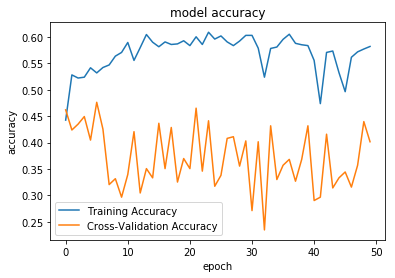

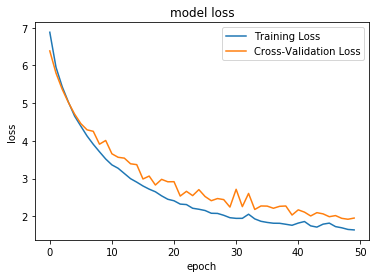

Training Model CNN_10.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 999, 62)           248       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 62)           248       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 62)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 999, 16)           2992      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999, 16)           64        
_________________________________________________________________
activation_2 (Activation)    (None, 999, 16)     

Accuracy 0.19047619047619047


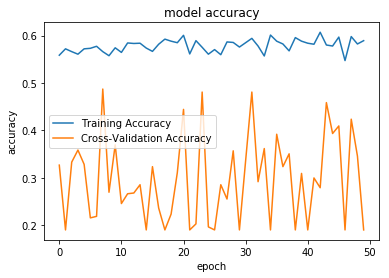

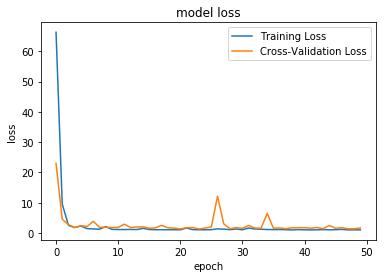

Training Model DeepConvLSTM_11.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
reshape_1 (Reshape)          (None, 999, 1, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 999, 1, 38)        152       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 1, 38)        152       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 1, 38)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 999, 1, 61)        7015      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999,

Accuracy 0.48253968253968255


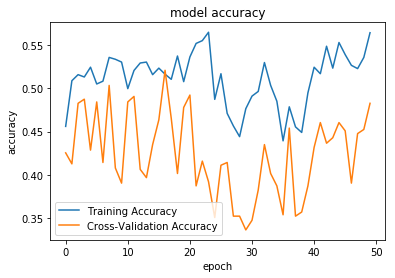

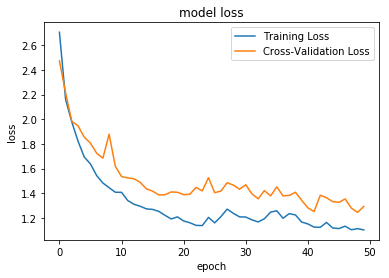

Training Model DeepConvLSTM_12.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
reshape_1 (Reshape)          (None, 999, 1, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 999, 1, 50)        200       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 1, 50)        200       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 1, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 999, 1, 29)        4379      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999,

Accuracy 0.38095238095238093


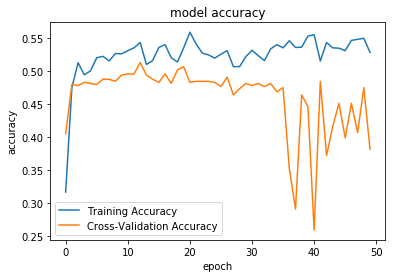

Training Model CNN_13.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 999, 57)           228       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 57)           228       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 57)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 999, 52)           8944      
_________________________________________________________________
batch_normalization_3 (Batch (None, 999, 52)           208       
_________________________________________________________________
activation_2 (Activation)    (None, 999, 52)     

Accuracy 0.5158730154945737


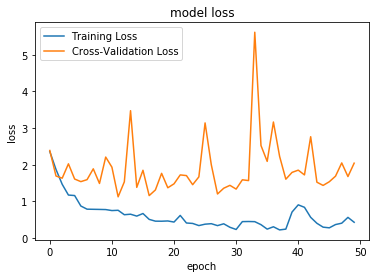

Training Model DeepConvLSTM_14.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 999, 1)            4         
_________________________________________________________________
reshape_1 (Reshape)          (None, 999, 1, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 999, 1, 36)        144       
_________________________________________________________________
batch_normalization_2 (Batch (None, 999, 1, 36)        144       
_________________________________________________________________
activation_1 (Activation)    (None, 999, 1, 36)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 999, 36)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 999,

Accuracy 0.5206349196888151


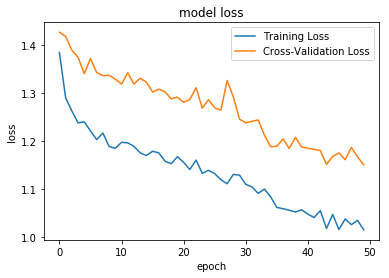

In [7]:
accuracy,parameters,modelnames=runModelSearch(numberOfModels=15,numberOfRepetitions=1)

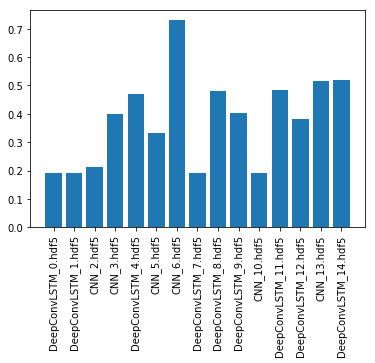

In [9]:
plt.figure()
plt.bar(modelnames,accuracy)
plt.xticks(rotation=90)
plt.show()

In [9]:
bestmodelIDX=np.argmax(accuracy)
print("Best Model {} Accuracy {}".format(modelnames[bestmodelIDX],accuracy[bestmodelIDX]))

Best Model CNN_6.hdf5 Accuracy 0.7301587301587301
